In [64]:
import pandas as pd
import numpy as np
import networkx as nx
from collections import Counter
import matplotlib.pyplot as plt
from tqdm import tqdm

# Import the data 

In [65]:
file_name = 'data/climate_videos.jsonl'
df = pd.read_json(file_name, lines=True)
df.set_index('display_id', inplace=True)
df = df.iloc[:100]
df.head()

,categories,channel_id,crawl_date,description,dislike_count,duration,like_count,tags,title,upload_date,view_count
display_id,,,,,,,,,,,
XPSYzLZ7xKU,Science & Technology,UCzWQYUVCpZqtN93H8RR44Qw,2019-11-03 22:21:31.549534,Climate change threatens to make dry regions e...,503.0,200,15328.0,"seeker,science,curiosity,education,explain,lea...",Transforming Air Into Pure Drinking Water Is F...,2019-10-03 00:00:00,357909.0
8riq9piAdiE,Science & Technology,UCzWQYUVCpZqtN93H8RR44Qw,2019-11-03 22:21:39.784993,Carbon pollution is being sucked from the sky ...,288.0,291,7980.0,"seeker,science,curiosity,education,explain,lea...",Could Injecting Carbon Into the Earth Save Our...,2019-09-19 00:00:00,176894.0
yeVLjOTThEM,Science & Technology,UCzWQYUVCpZqtN93H8RR44Qw,2019-11-03 22:21:47.579992,"Contrary to popular belief, the Amazon forest ...",623.0,272,12140.0,"seeker,science,curiosity,education,explain,lea...",The Amazon Rainforest Doesn’t Produce 20% of O...,2019-09-04 00:00:00,269588.0
-fNCUzVRcL4,Science & Technology,UCzWQYUVCpZqtN93H8RR44Qw,2019-11-03 22:21:58.628372,An international team of scientists has embark...,90.0,386,4007.0,"focal point,documentary,interview,short doc,sc...","Glaciers Are Collapsing, Here's Why We Need a ...",2019-08-11 00:00:00,113987.0
-3YhFNs1XNY,Science & Technology,UCzWQYUVCpZqtN93H8RR44Qw,2019-11-03 22:21:05.226949,NASA and the ISRO are planning on venturing to...,242.0,264,8245.0,"seeker,science,curiosity,education,explain,lea...",Why Scientists Are Exploring Earth’s Dangerous...,2019-07-05 00:00:00,264279.0


# Convert tags into a list of tags

In [66]:
data = df['tags'].copy()
data = data.apply(lambda x: x.split(','))
data

display_id
XPSYzLZ7xKU    [seeker, science, curiosity, education, explai...
8riq9piAdiE    [seeker, science, curiosity, education, explai...
yeVLjOTThEM    [seeker, science, curiosity, education, explai...
-fNCUzVRcL4    [focal point, documentary, interview, short do...
-3YhFNs1XNY    [seeker, science, curiosity, education, explai...
                                     ...                        
OX9m-_wSAIM    [climate change, drought, drought resistance, ...
L7oklmbtxoY    [science funding, federal funding for science,...
PD88nTu8TTI    [microplastic, microbeads, the beads in face w...
-hRbq1wJS_U    [hair, why do we have eyebrows, eyebrows, why ...
z9yHKhwc2xc    [infrasound, sound waves, low frequency sound ...
Name: tags, Length: 100, dtype: object

# Take a look at the tag counts

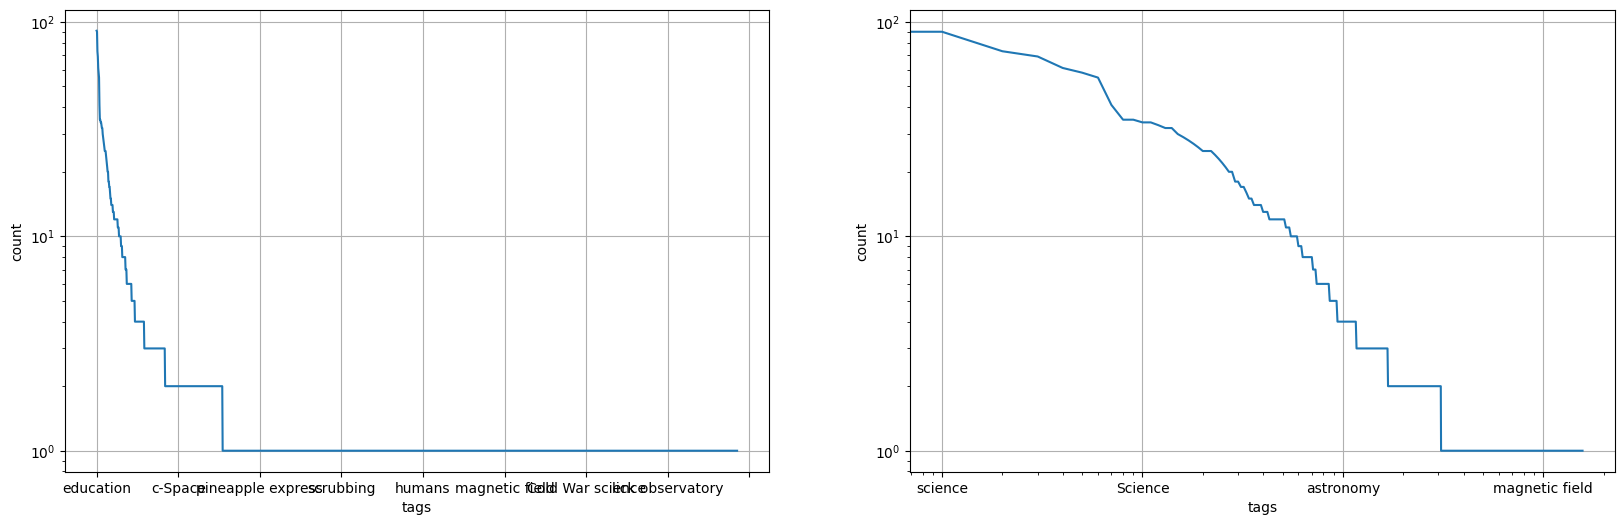

education              91
science                90
current events         73
discovery news         69
dnews                  61
                       ..
protocol                1
montreal                1
layer                   1
Ozone                   1
c-Health & Medicine     1
Length: 1571, dtype: int64

In [67]:
tags_count = pd.Series(dict(Counter(tag for tags in data for tag in tags)))
tags_count.sort_values(inplace=True, ascending=False)

fig, ax = plt.subplots(1, 2, figsize=(20, 6))
tags_count.plot(xlabel='tags', ylabel='count', ax=ax[0], logy=True, logx=False, grid=True)
tags_count.plot(xlabel='tags', ylabel='count', ax=ax[1], logy=True, logx=True, grid=True)
plt.show()
tags_count

# Only keep the top 90th percentile of tags 

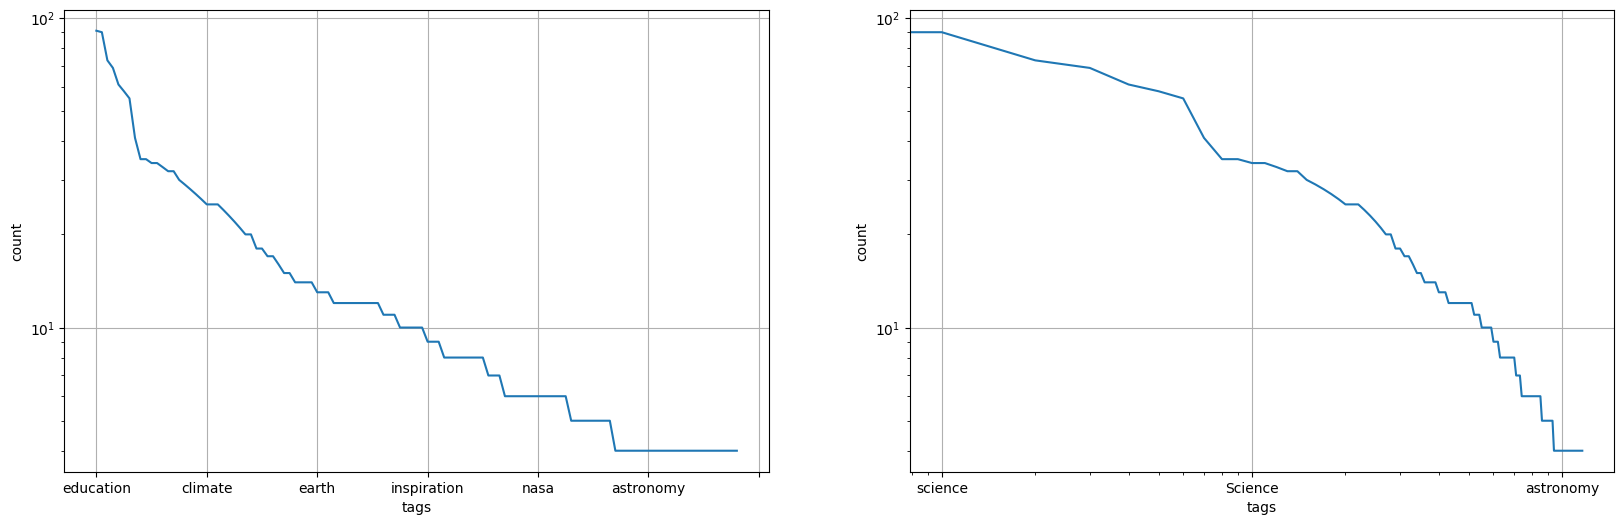

education                  91
science                    90
current events             73
discovery news             69
dnews                      61
                           ..
Video                       4
change                      4
discover                    4
is climate change real      4
science in the extremes     4
Length: 117, dtype: int64

In [68]:
threshold = tags_count.quantile(0.9)
common_tags_count = tags_count[tags_count > threshold]
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
common_tags_count.plot(xlabel='tags', ylabel='count', ax=ax[0], logy=True, logx=False, grid=True)
common_tags_count.plot(xlabel='tags', ylabel='count', ax=ax[1], logy=True, logx=True, grid=True)
plt.show()
common_tags_count

# Filter the tags in the dataframe

In [69]:
common_tags = set(common_tags_count.index)
data = data.apply(lambda x: [tag for tag in x if tag in common_tags])

# Create the bipartite graph between videos and tags

In [70]:
G = nx.Graph()
G.add_nodes_from(common_tags, bipartite=0)
G.add_nodes_from(list(data.index), bipartite=1)

for video, tags in tqdm(data.items(), total=len(data)):
    for tag in tags:
        G.add_edge(video, tag)
print(G)

100%|██████████| 100/100 [00:00<00:00, 39862.23it/s]

Graph with 217 nodes and 1836 edges


# Project the graph onto the videos

In [71]:
print("Start")
tag_graph = nx.bipartite.weighted_projected_graph(G, common_tags)
print(tag_graph)

Start
Graph with 117 nodes and 3852 edges


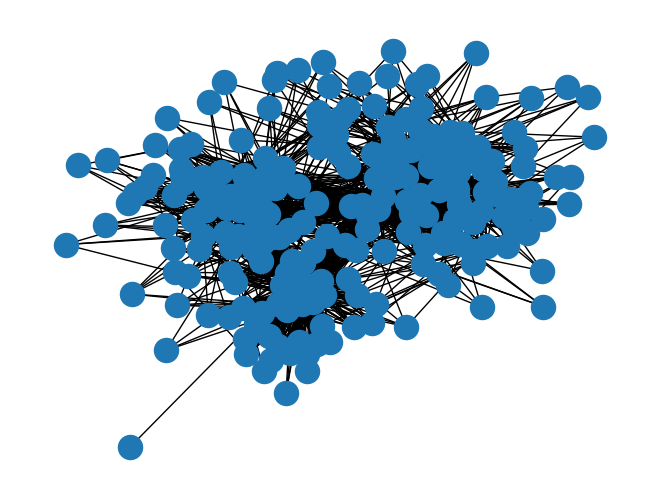

In [72]:
nx.draw(G)

In [73]:
edges = tag_graph.edges.data('weight')
weights = [w for u, v, w in edges]
threshold = np.percentile(weights, 99)
filtered_edges = [(u, v, w) for u, v, w in edges if w > threshold]
print(len(filtered_edges))

filtered_graph = nx.Graph()
filtered_graph.add_weighted_edges_from(filtered_edges)
print(filtered_graph)

31
Graph with 12 nodes and 31 edges


In [75]:
# PLot the graph with edge width == edge weigth

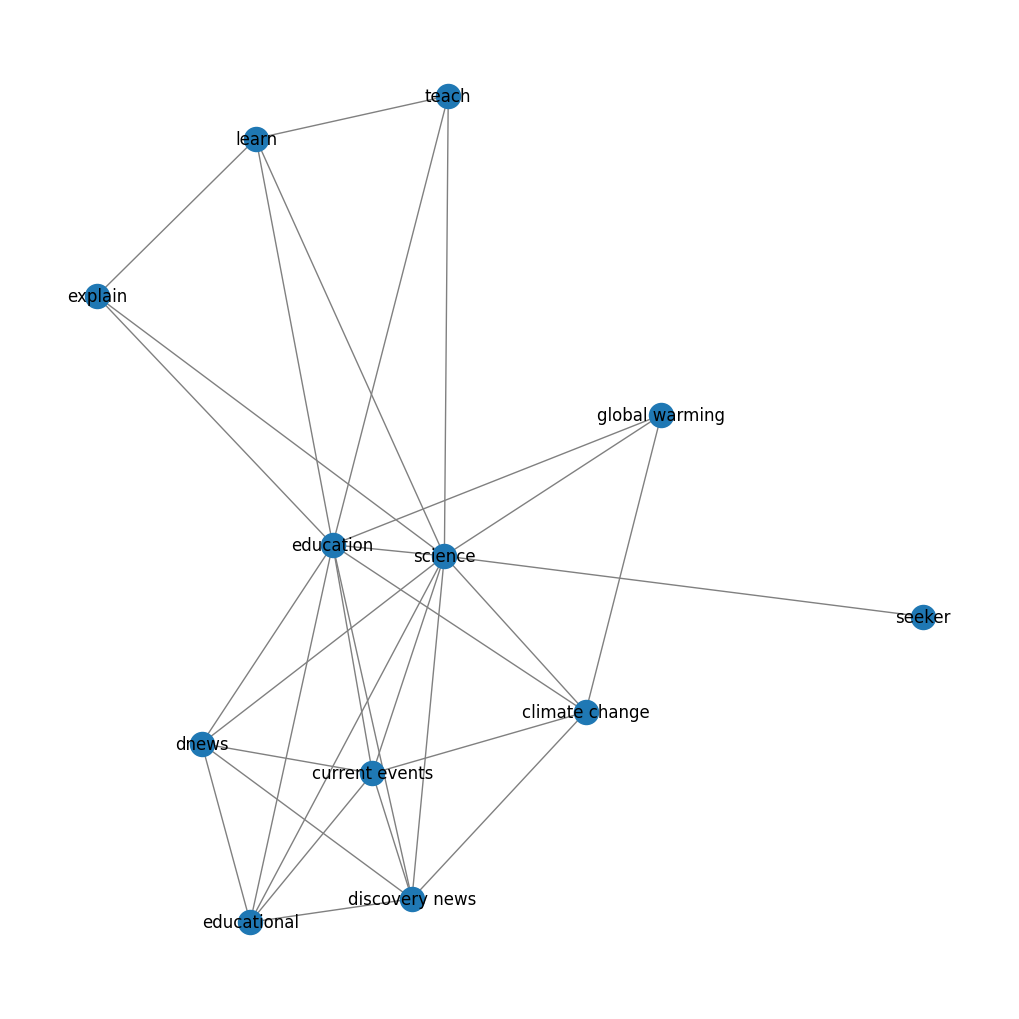

In [81]:
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(filtered_graph)
nx.draw(filtered_graph, pos, edge_color='grey', with_labels=True)
plt.show()